# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `df_copy` is a copy of the original dataframe `df` and is used only at the start of the data cleaning process in Question 1.
- `df` used from Question 3 onwards is a new dataframe created by using a cleaned .csv file that is created at the end of Question 2. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime
from sklearn.cluster import DBSCAN
import folium
import builtins

Reading in the .csv and creating a dataframe.

In [46]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

KeyboardInterrupt: 

### Question 1: Data Cleaning

1. There are several outliers in the data. Identify these and give justification for why you can remove them from the analysis. (Hint: look at trip duration, speed, distance, etc).
    1. Initial Exploration: Check for missing values, basic statistics, and unusual data points.
    2. Outlier Detection Using Boxplots:
        - **Trip Duration:** Create a boxplot to visualize the distribution of trip durations. Identify outliers as trips with durations significantly shorter or longer than the typical range, based on the Interquartile Range (IQR) method.
        - **Distance Calculation:** Calculate the trip distance using the Haversine formula, which measures the great-circle distance between the pickup and dropoff locations. Use a boxplot to detect outliers in the trip distance data.
        - **Speed Calculation:** Compute the average speed for each trip using the calculated distance and trip duration. Create a boxplot to identify trips with implausibly high or low speeds, indicating potential data entry errors or anomalies.
    3. Remove Outliers: For each of the three variables (trip duration, distance, and speed), remove data points identified as outliers using the IQR method. Outliers are defined as values outside the range of `(Q1 - 1.5 x IQR)` and `(Q3 + 1.5 x IQR)` are the first and third quartiles, respectively.

Initial Exploration: Check for missing values, basic statistics, and unusual data points.

In [22]:
display(df_copy.info())
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [23]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Missing values in each column: 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


Trip Duration Outlier Detection

In [24]:
# Convert the trip duration to minutes
df_copy['trip_duration_min'] = df_copy['trip_duration'] / 60
display(df_copy[['trip_duration', 'trip_duration_min']].head())

,trip_duration,trip_duration_min
0,455,7.583
1,663,11.050
2,2124,35.400
3,429,7.150
4,435,7.250


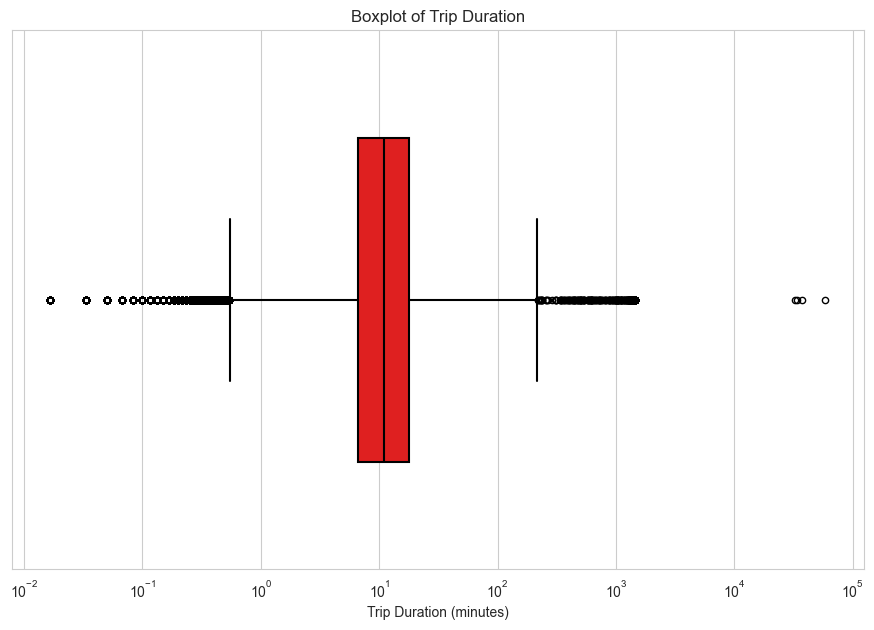

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot the trip duration to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.set_style('whitegrid')
sns.boxplot(
    x=df_copy["trip_duration_min"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Duration (minutes)')
plt.title('Boxplot of Trip Duration')
plt.savefig('./Plots/Plots[1]/trip_duration_boxplot.png')
plt.show()
plt.clf()

In [26]:
# Define thresholds based on boxplot (IQR method)
Q1_duration = df_copy['trip_duration_min'].quantile(0.25)
Q3_duration = df_copy['trip_duration_min'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Outliers are typically defined as points beyond 1.5 times the IQR
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

print(f'Q1_duration: {Q1_duration}')
print(f'Q3_duration: {Q3_duration}')
print(f'IQR_duration: {IQR_duration}')
print(f'Lower bound: {lower_bound_duration}')
print(f'Upper bound: {upper_bound_duration}')

# Number of entries before cleaning
original_count = len(df_copy)

# Remove outliers for trip duration
df_cleaned = df_copy[(df_copy['trip_duration_min'] > lower_bound_duration) & (df_copy['trip_duration_min'] < upper_bound_duration)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_duration: 6.616666666666666
Q3_duration: 17.916666666666668
IQR_duration: 11.3
Lower bound: -10.333333333333336
Upper bound: 34.866666666666674
Original number of entries: 1458644
Number of entries after cleaning: 1384424
Number of entries removed: 74220


Trip Distance Outlier Detection

In [27]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = builtins.map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])

display(df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

C:\Users\zachs\AppData\Local\Temp\ipykernel_40928\2331265758.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.982,40.768,-73.965,40.766,1.498
1,-73.980,40.739,-73.999,40.731,1.804
3,-74.010,40.720,-74.012,40.707,1.485
4,-73.973,40.793,-73.973,40.783,1.188
5,-73.983,40.742,-73.992,40.749,1.098


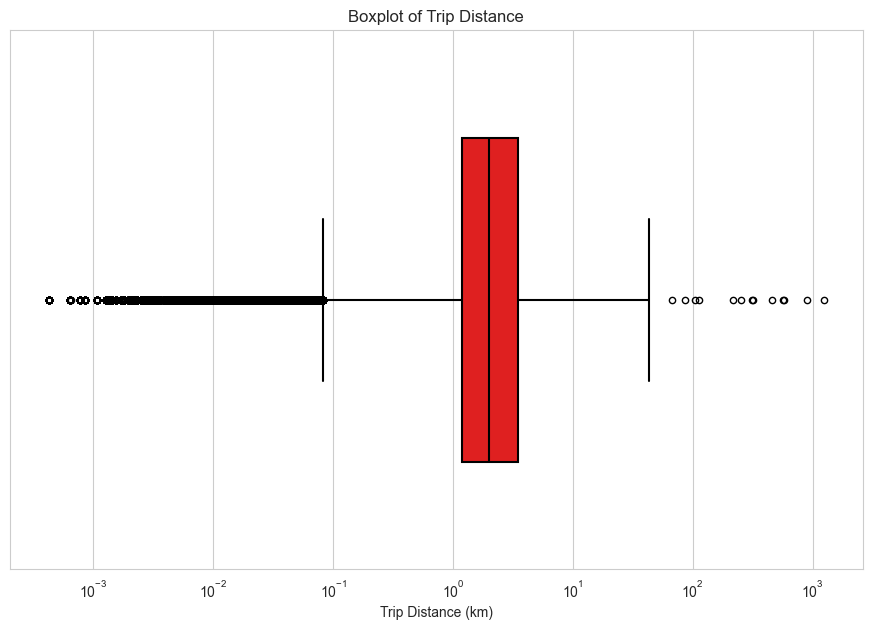

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot the trip distance to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["trip_distance_km"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Distance (km)')
plt.title('Boxplot of Trip Distance')
plt.savefig('./Plots/Plots[1]/trip_distance_boxplot.png')
plt.show()
plt.clf()

In [29]:
# Define thresholds based on boxplot (IQR method)
Q1_distance = df_cleaned['trip_distance_km'].quantile(0.25)
Q3_distance = df_cleaned['trip_distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance

lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance

print(f'Q1_distance: {Q1_distance}')
print(f'Q3_distance: {Q3_distance}')
print(f'IQR_distance: {IQR_distance}')
print(f'Lower bound: {lower_bound_distance}')
print(f'Upper bound: {upper_bound_distance}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip distance
df_cleaned = df_cleaned[(df_cleaned['trip_distance_km'] > lower_bound_distance) & (df_cleaned['trip_distance_km'] < upper_bound_distance)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_distance: 1.1974858282621814
Q3_distance: 3.483906343696884
IQR_distance: 2.2864205154347026
Lower bound: -2.2321449448898725
Upper bound: 6.9135371168489375
Original number of entries: 1384424
Number of entries after cleaning: 1276732
Number of entries removed: 107692


Trip Speed Outlier Detection

In [30]:
df_cleaned['speed_kmh'] = df_cleaned['trip_distance_km'] / (df_cleaned['trip_duration'] / 3600)
display(df_cleaned[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

,trip_distance_km,trip_duration,speed_kmh
0,1.498,455,11.849
1,1.804,663,9.798
3,1.485,429,12.458
4,1.188,435,9.830
5,1.098,443,8.925


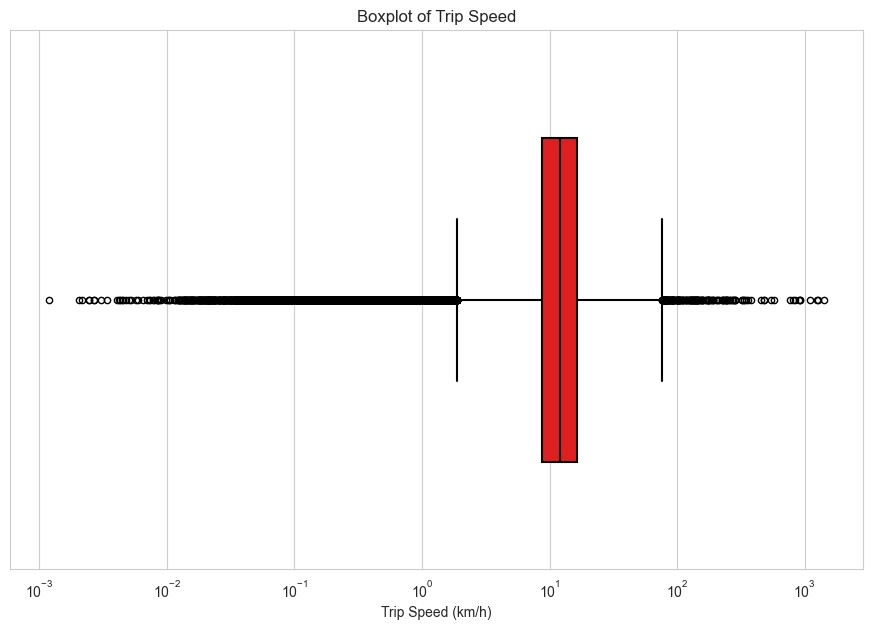

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot the trip speed to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["speed_kmh"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [32]:
# Define thresholds based on boxplot (IQR method)
Q1_speed = df_cleaned['speed_kmh'].quantile(0.25)
Q3_speed = df_cleaned['speed_kmh'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed

lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

print(f'Q1_speed: {Q1_speed}')
print(f'Q3_speed: {Q3_speed}')
print(f'IQR_speed: {IQR_speed}')
print(f'Lower bound: {lower_bound_speed}')
print(f'Upper bound: {upper_bound_speed}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip speed
df_cleaned = df_cleaned[(df_cleaned['speed_kmh'] > lower_bound_speed) & (df_cleaned['speed_kmh'] < upper_bound_speed)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_speed: 8.783111873053258
Q3_speed: 16.27753997881952
IQR_speed: 7.494428105766261
Lower bound: -2.458530285596133
Upper bound: 27.51918213746891


Original number of entries: 1276732
Number of entries after cleaning: 1236820
Number of entries removed: 39912


In [33]:
# Final cleaned dataset
print("Shape of cleaned dataset: ", df_cleaned.shape)
display(df_cleaned.head())

Shape of cleaned dataset:  (1236820, 14)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_min,trip_distance_km,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,7.583,1.498,11.849
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,11.050,1.804,9.798
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,7.150,1.485,12.458
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,7.250,1.188,9.830
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,N,443,7.383,1.098,8.925


**Outlier Identification and Justification for Removal**

**1. Trip Duration Outliers**

- **Analysis**: 
  - The first and third quartiles (Q1 and Q3) of trip duration are approximately 6.62 minutes and 17.92 minutes, respectively, resulting in an Interquartile Range (IQR) of 11.3 minutes.
  - Outliers were identified as trips with durations below the lower bound of -10.33 minutes or above the upper bound of 34.87 minutes. Since negative durations are not possible, only the upper bound was considered.
  - **Results**: After applying this threshold, 74,220 entries were removed, reducing the dataset from 1,458,644 to 1,384,424 entries.

- **Justification for Removal**:
  - **Extreme durations**: Trips with durations significantly longer than the upper bound may result from data entry errors, traffic anomalies, or scenarios where the taxi meter was left running unintentionally. These extreme cases do not represent typical taxi trips and could distort the analysis of average trip times and patterns.

**2. Trip Distance Outliers**

- **Analysis**:
  - The IQR for trip distance was calculated as 2.29 km, with Q1 at 1.20 km and Q3 at 3.48 km. The lower bound was -2.23 km (which is not physically possible) and the upper bound was 6.91 km.
  - **Results**: Applying this threshold removed 107,692 entries, reducing the dataset further to 1,276,732 entries.

- **Justification for Removal**:
  - **Improbable distances**: Trips with distances far exceeding the upper bound may indicate unusually long journeys, possibly due to outliers in pickup/dropoff coordinates or GPS errors. These outliers could mislead any spatial analysis or skew results concerning the typical distance traveled in NYC.

**3. Speed Outliers**

- **Analysis**:
  - For speed, the IQR was 7.49 km/h, with Q1 at 8.78 km/h and Q3 at 16.28 km/h, leading to a lower bound of -2.46 km/h (impossible for real trips) and an upper bound of 27.52 km/h.
  - **Results**: This step removed 39,912 entries, leaving a final dataset of 1,236,820 entries.

- **Justification for Removal**:
  - **Unrealistic speeds**: Extremely high speeds may occur due to incorrect time or distance calculations, possibly indicating data errors or misrecorded trips. Similarly, very low speeds could result from trips that involved significant waiting time, or errors where the vehicle might not have moved but the trip was recorded. Removing these ensures that the analysis focuses on realistic driving conditions, leading to more accurate insights into traffic patterns and trip efficiency.

**Summary**

Outliers across trip duration, distance, and speed were systematically identified using boxplots and the IQR method. Removing these outliers is essential to maintain data integrity, representativeness, and statistical robustness in the analysis. The process ensures that the dataset accurately reflects typical taxi trips in NYC, enabling more reliable and meaningful conclusions from subsequent analyses.

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [34]:
display(df_cleaned[['trip_distance_km', 'speed_kmh']])

,trip_distance_km,speed_kmh
0,1.498,11.849
1,1.804,9.798
3,1.485,12.458
4,1.188,9.830
5,1.098,8.925
...,...,...
1458637,3.535,16.746
1458638,2.316,20.139
1458639,1.224,5.665
1458642,1.092,10.538


In [35]:
# Extract day of the week

# Convert pickup and dropoff datetime columns to datetime objects
df_cleaned['pickup_datetime'] = pd.to_datetime(df_cleaned['pickup_datetime'])
df_cleaned['dropoff_datetime'] = pd.to_datetime(df_cleaned['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df_cleaned['day_of_week_str'] = df_cleaned['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df_cleaned['pickup_hour'] = df_cleaned['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['time_of_day'] = df_cleaned['pickup_hour'].apply(time_of_day)

# All new features
display(df_cleaned[['trip_distance_km', 'speed_kmh', 'day_of_week', 'day_of_week_str', 'pickup_hour', 'time_of_day']].head())

# Save the cleaned and feature-enhanced DataFrame for further analysis
df_cleaned.to_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv', index=False)

,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day
0,1.498,11.849,0,Monday,17,Evening
1,1.804,9.798,6,Sunday,0,Night
3,1.485,12.458,2,Wednesday,19,Evening
4,1.188,9.830,5,Saturday,13,Afternoon
5,1.098,8.925,5,Saturday,22,Night


### Question 3: Time-based

**[3.1]** Which day of the week is the most popular? Show plots to motivate your answer.

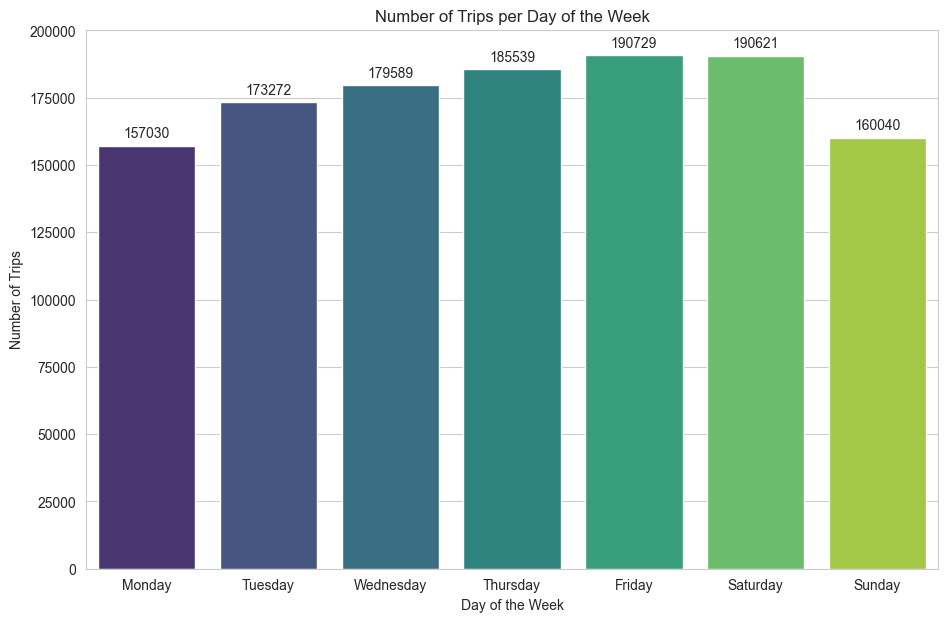

<Figure size 640x480 with 0 Axes>

In [36]:
# Read the cleaned dataset
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv')

day_of_week_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x=days, y=day_of_week_counts, hue=days, dodge=False, estimator="sum", palette='viridis')

# Add the total above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of the Week')
plt.savefig('./Plots/Plots[3]/Plots[3.1]/num_of_trips_per_day_of_the_week.png')
plt.show()
plt.clf()

Friday is the most popular day of the week.

**[3.2]** What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

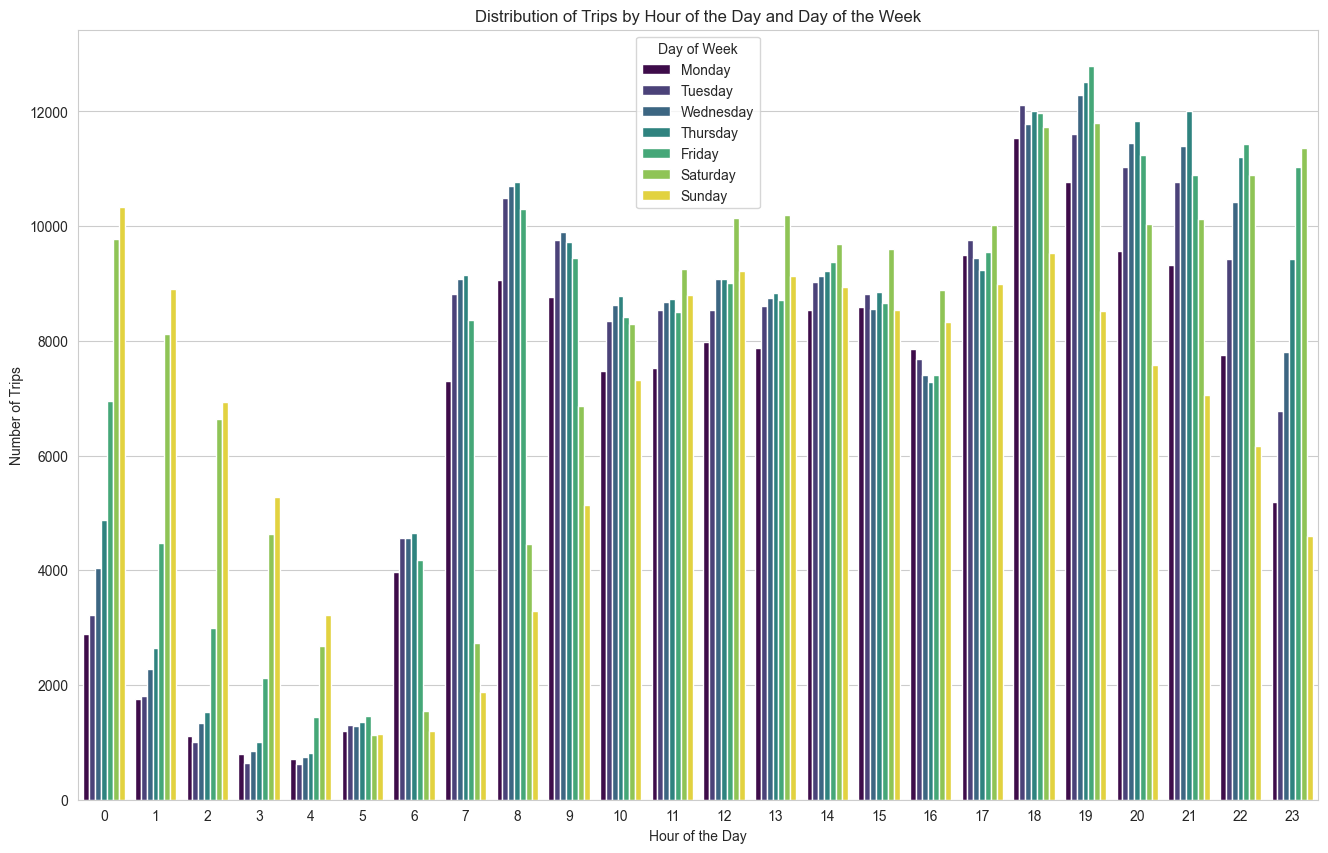

The most popular hour overall is: 18


<Figure size 640x480 with 0 Axes>

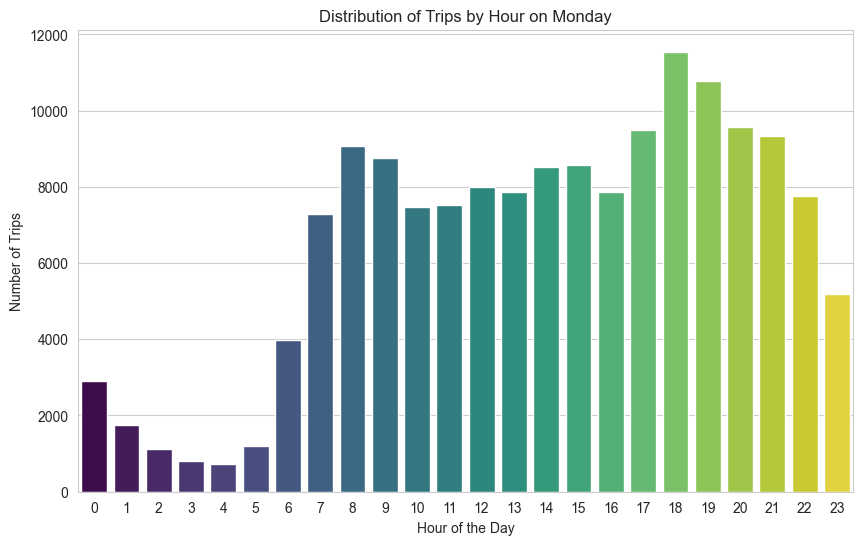

The most popular hour on Monday is: 18


<Figure size 640x480 with 0 Axes>

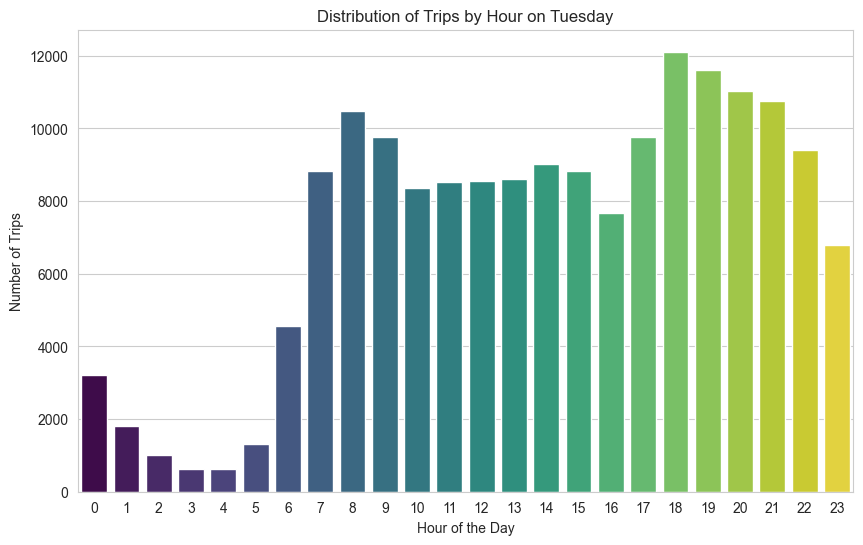

The most popular hour on Tuesday is: 18


<Figure size 640x480 with 0 Axes>

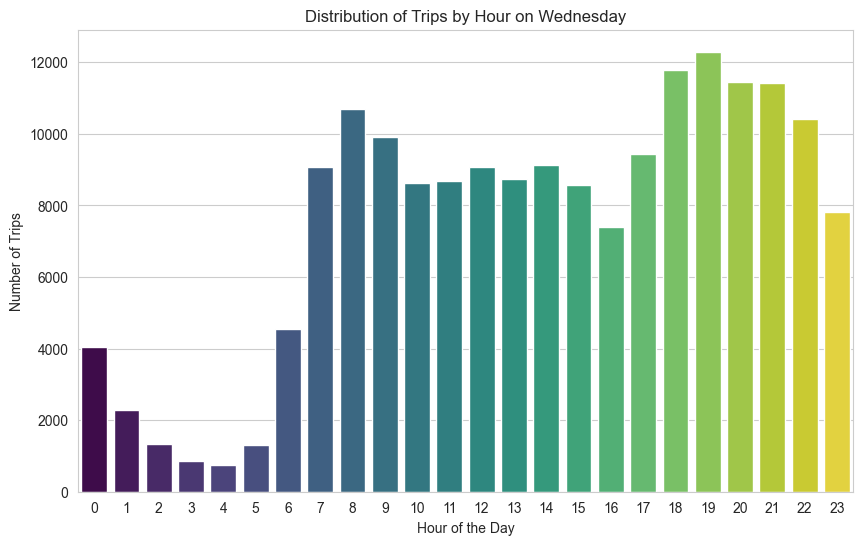

The most popular hour on Wednesday is: 19


<Figure size 640x480 with 0 Axes>

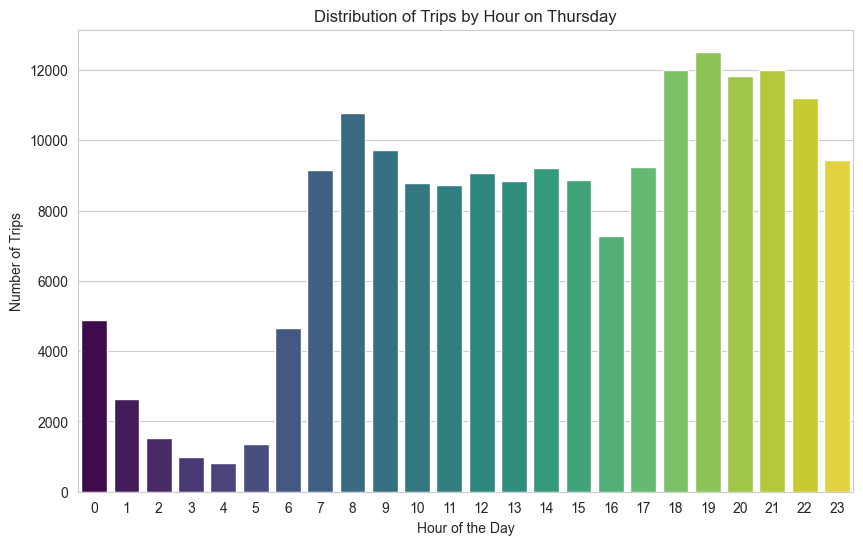

The most popular hour on Thursday is: 19


<Figure size 640x480 with 0 Axes>

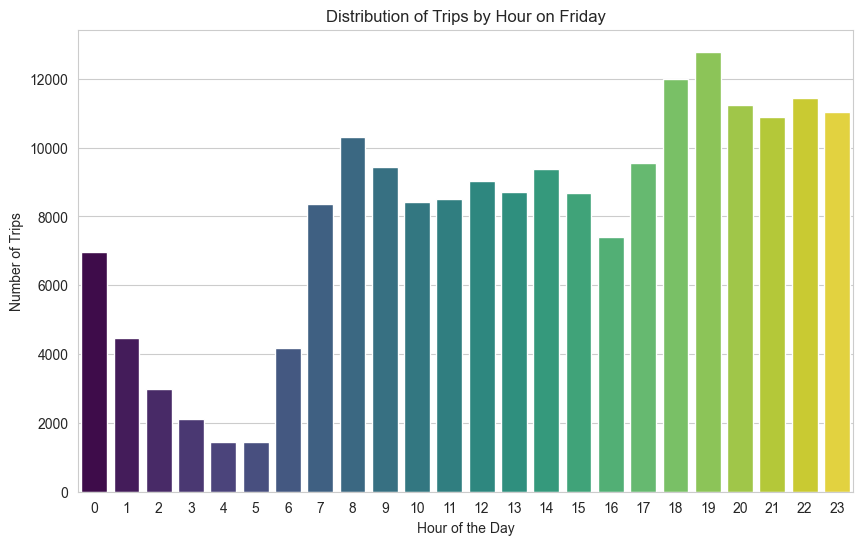

The most popular hour on Friday is: 19


<Figure size 640x480 with 0 Axes>

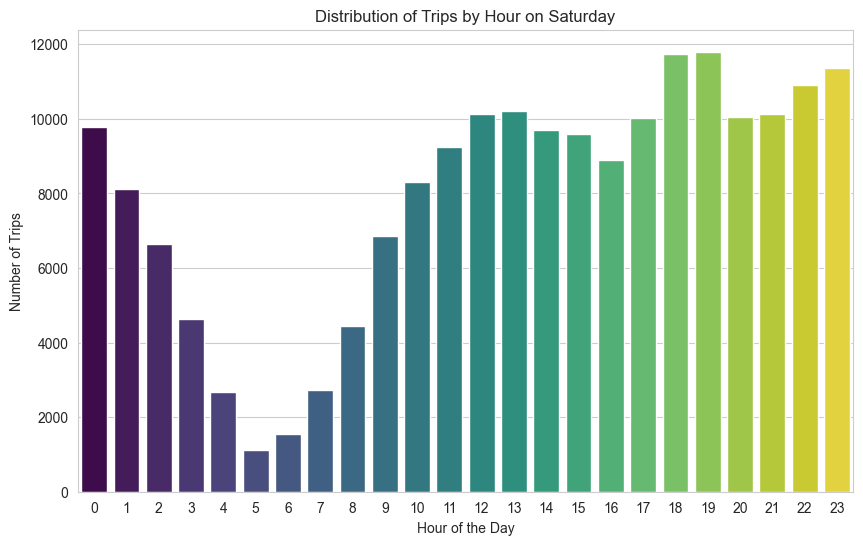

The most popular hour on Saturday is: 19


<Figure size 640x480 with 0 Axes>

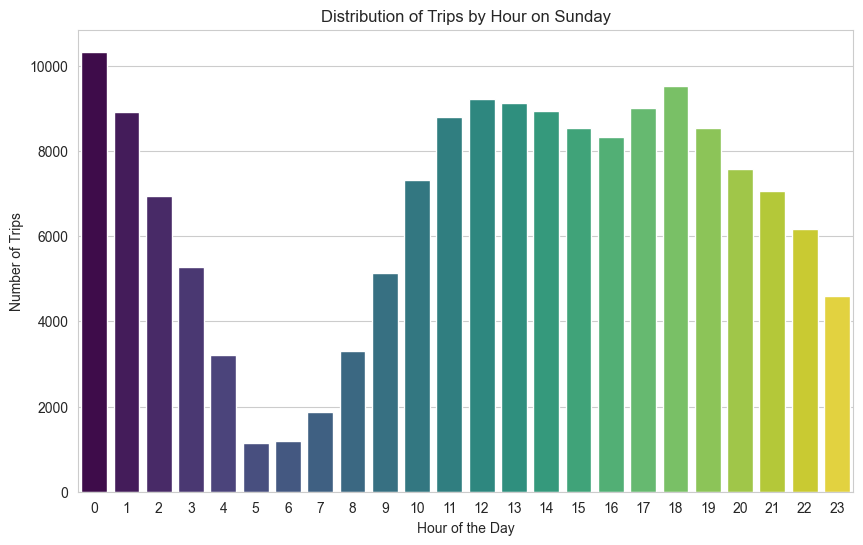

The most popular hour on Sunday is: 0


<Figure size 640x480 with 0 Axes>

In [37]:
import os

# Define the folder to save the plots
output_folder = './Plots/Plots[3]/Plots[3.2]'
os.makedirs(output_folder, exist_ok=True)

# Define the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Overall distribution of trips by hour and day of the week
plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='pickup_hour', hue='day_of_week', palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of the Day and Day of the Week')
plt.legend(title='Day of Week', labels=days)
plt.savefig(os.path.join(output_folder, 'trips_by_hour_of_the_day_and_day_of_the_week.png'))
plt.show()
plt.clf()

# Print the most popular hour overall
most_popular_hour_overall = df['pickup_hour'].mode()[0]
print(f'The most popular hour overall is: {most_popular_hour_overall}')

# Individual plots for each day of the week
for i, day in enumerate(days):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df[df['day_of_week'] == i], x='pickup_hour', hue='pickup_hour', palette='viridis', legend=False)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Distribution of Trips by Hour on {day}')
    plt.savefig(os.path.join(output_folder, f'trips_by_hour_on_{day.lower()}.png'))
    plt.show()
    plt.clf()
    
    # Print the most popular hour for each day
    most_popular_hour = df[df['day_of_week'] == i]['pickup_hour'].mode()[0]
    print(f'The most popular hour on {day} is: {most_popular_hour}')

**[3.3]** Investigate the differences between weekdays and weekends. What would account for this? 

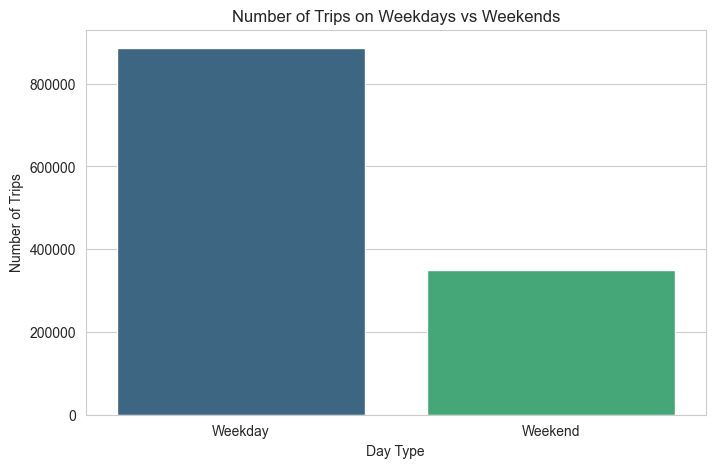

<Figure size 640x480 with 0 Axes>

In [38]:
# Create a new column indicating whether the day is a weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Compare trips on weekdays vs weekends
weekend_vs_weekday_counts = df['is_weekend'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_vs_weekday_counts, hue=['Weekday', 'Weekend'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Weekdays vs Weekends')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/num_trips_on_weekdays_vs_weekends.png')
plt.show()
plt.clf()

The bar plot visualizes the number of trips on weekdays compared to weekends. The data shows that significantly more trips occur on weekdays than on weekends. There are several factors that could account for this difference:

1. **Work and School Commutes**:
   - Weekdays typically have higher trip volumes because of regular work and school commutes. People travel to and from work, school, and other routine activities, contributing to the increased number of trips.

2. **Business Activity**:
   - Many businesses operate primarily during weekdays, which results in more trips for meetings, deliveries, and other business-related activities. This could explain the higher trip count on weekdays.

3. **Leisure vs. Routine Travel**:
   - Weekends are generally reserved for leisure activities, which may not require as many short or frequent trips as weekdays. Additionally, many people prefer to stay home or engage in fewer activities during weekends, reducing the overall demand for transportation.

4. **Public Transportation and Ride-Hailing Services**:
   - The availability and demand for public transportation and ride-hailing services might also differ between weekdays and weekends. On weekdays, people might rely more on these services to get to work or school, whereas on weekends, they may opt for alternative transportation or stay in, reducing trip numbers.

**[3.4]** Look at how these patterns change on the major holidays (do they change?). Look at the following: St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, Martin Luther King Day. Make sure you use the correct dates for these for the relevant year.

Steps/Explanation for [3.4] Analysis of Trip Patterns on Major Holidays

Objective: Analyze how trip patterns change on major holidays compared to regular days. The holidays of interest are St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, and Martin Luther King Day in 2016. Specifically, we want to determine if there are significant differences in the hourly distribution of trips and cumulative trip patterns on these holidays.

1. Identify Major Holidays in the Dataset:
    - We first define the dates of the major holidays in 2016 and convert these dates to datetime objects.
The dataset is then processed to include a new column, is_holiday, which indicates whether a trip occurred on a major holiday.

2. Overall Comparison of Trip Counts:
    - A bar plot is created to compare the total number of trips on holidays versus non-holidays. This provides an initial overview of how trip volumes differ on these special days.

3. Hourly Distribution of Trips on Each Holiday:
    - For each holiday, we plot the hourly distribution of trips. This allows us to visualize how trip activity varies throughout the day on each holiday.
    - We compare this distribution with regular days of the same weekday (e.g., compare Martin Luther King Day with other Mondays) to determine whether the holiday significantly alters travel behavior.
    - Additionally, we ensure that the comparison day (one week before the holiday) is not another major holiday to maintain a fair comparison.

4. Cumulative Distribution Function (CDF) Analysis:
    - We plot the Cumulative Distribution Function (CDF) for trips on each holiday and compare it with the CDF for trips on a regular day one week before the holiday. The CDF shows how trips accumulate over the course of the day, highlighting whether trips are more concentrated in the morning, afternoon, or evening on holidays versus regular days.
    - This analysis is crucial for understanding whether travel patterns are more spread out or clustered at certain times during holidays compared to typical weekdays or weekends.

Conclusion:
- This multi-faceted approach provides a comprehensive analysis of how trip patterns change on major holidays. By comparing hourly distributions and cumulative distributions, we gain valuable insights into whether holidays significantly affect travel behavior in New York City. These insights could be useful for understanding traffic management, service demand, and urban planning during holidays.


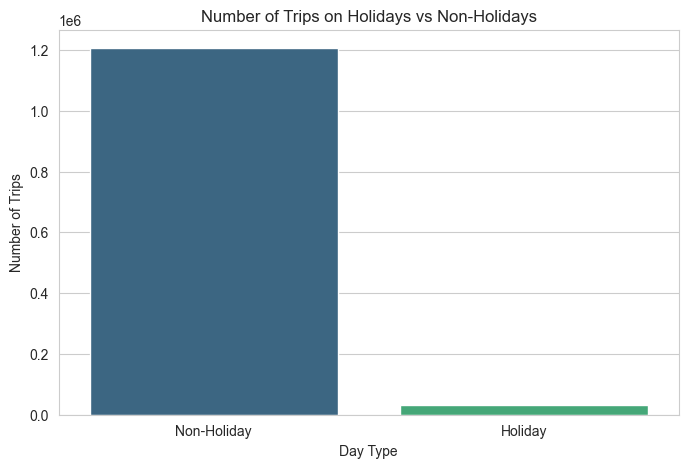

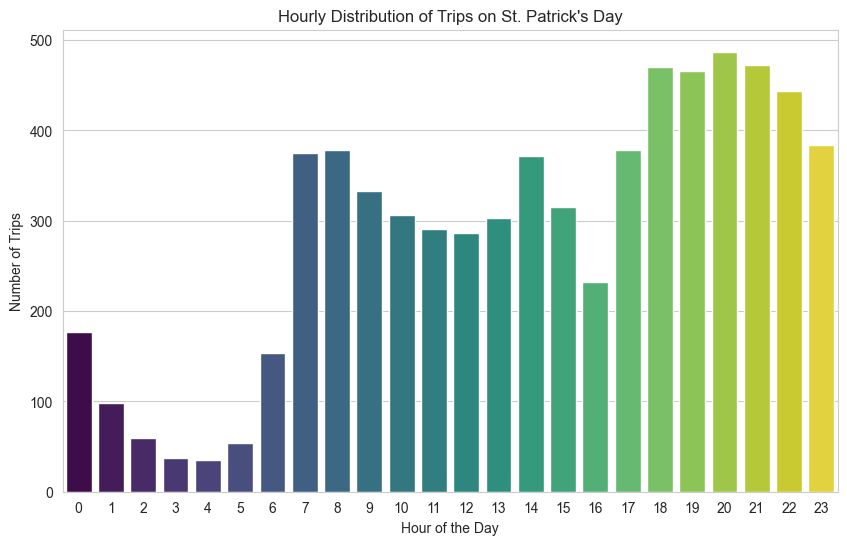

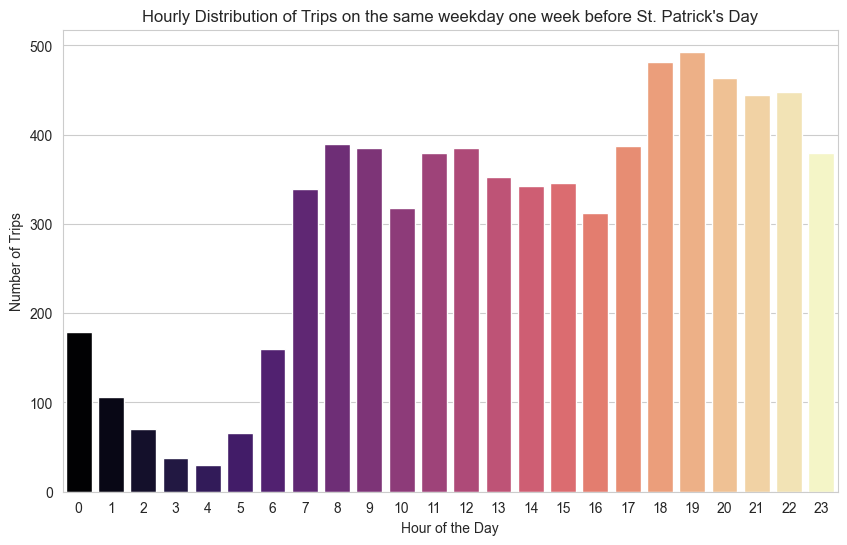

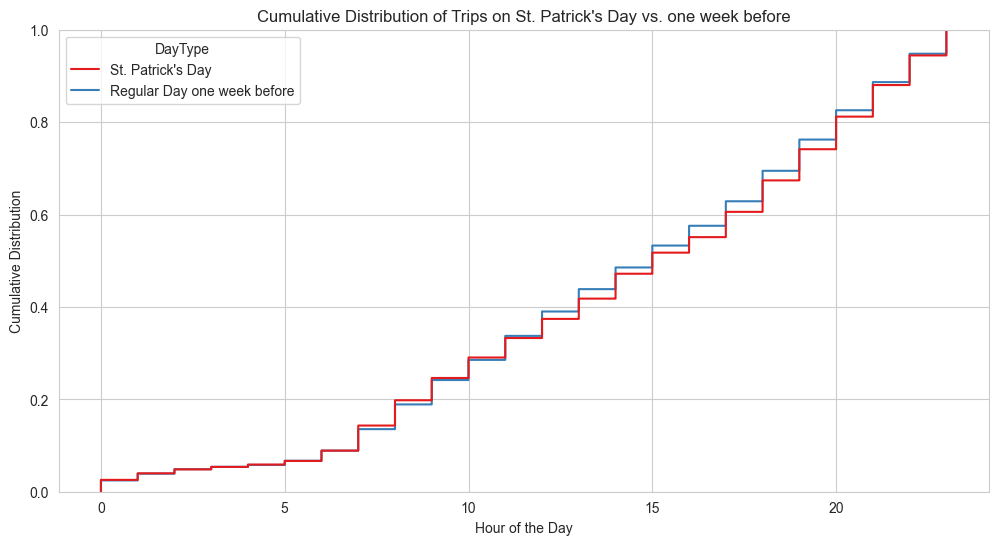

<Figure size 640x480 with 0 Axes>

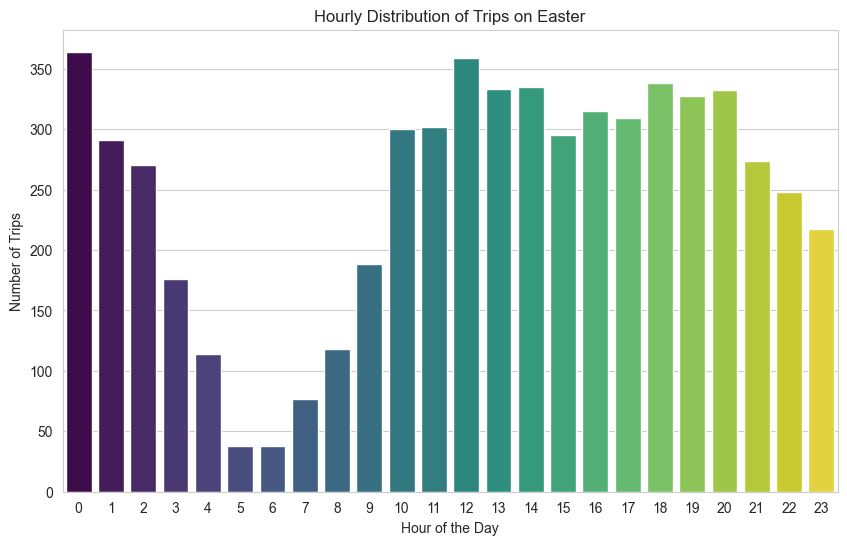

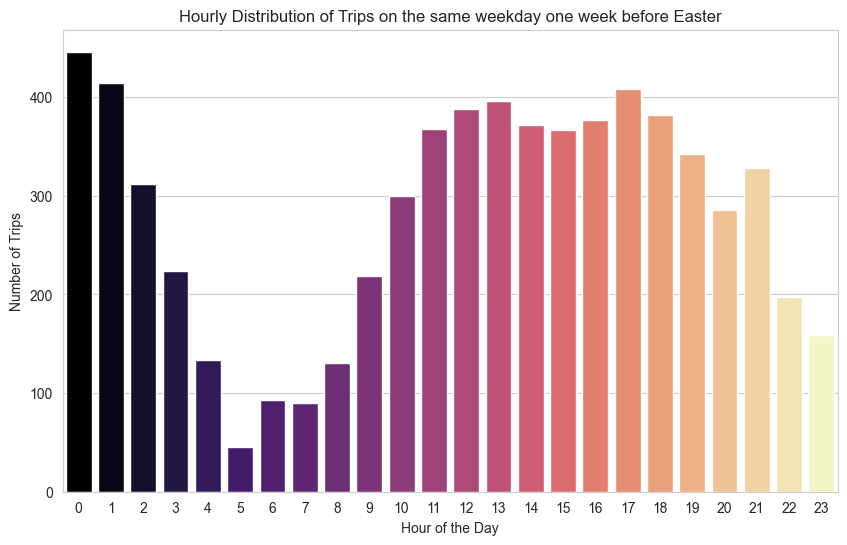

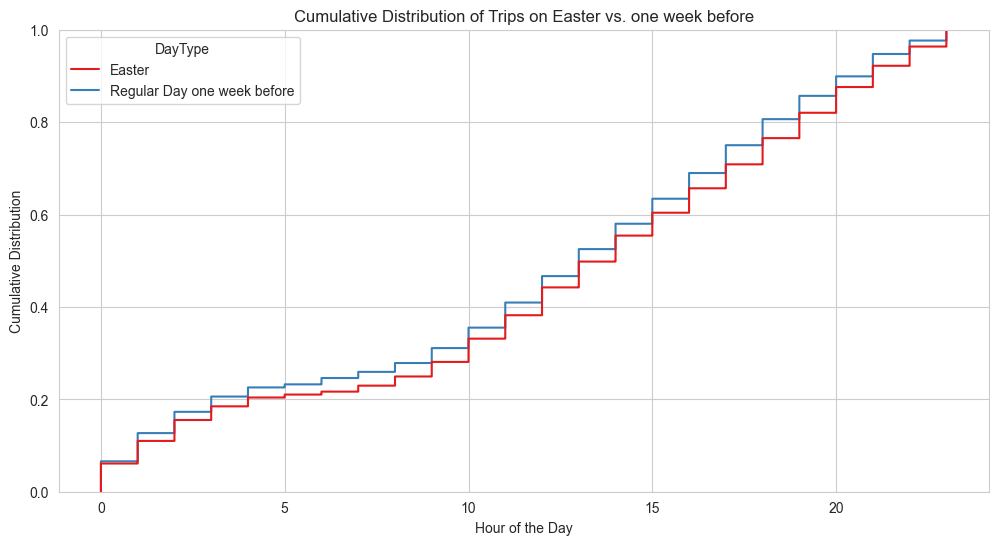

<Figure size 640x480 with 0 Axes>

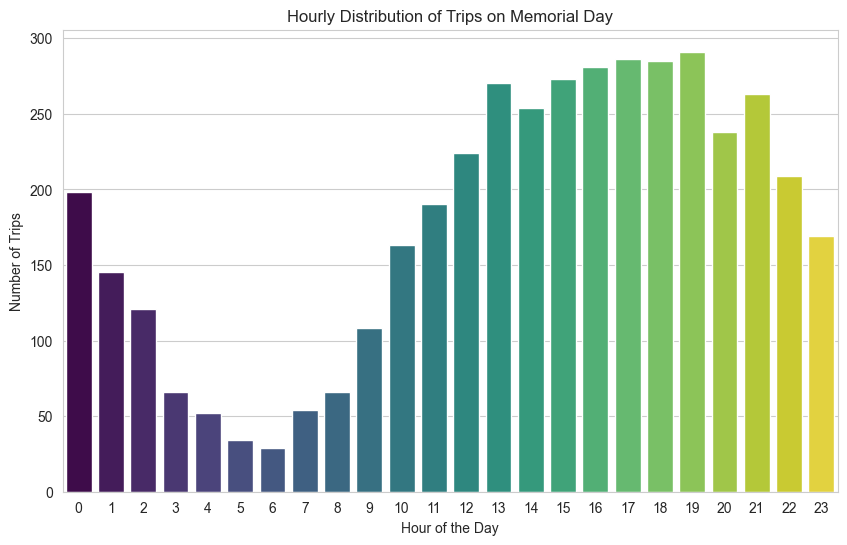

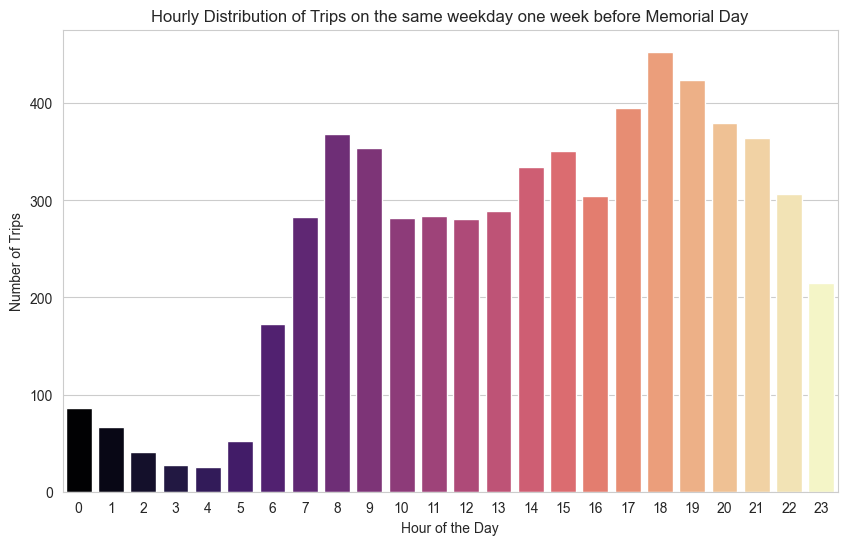

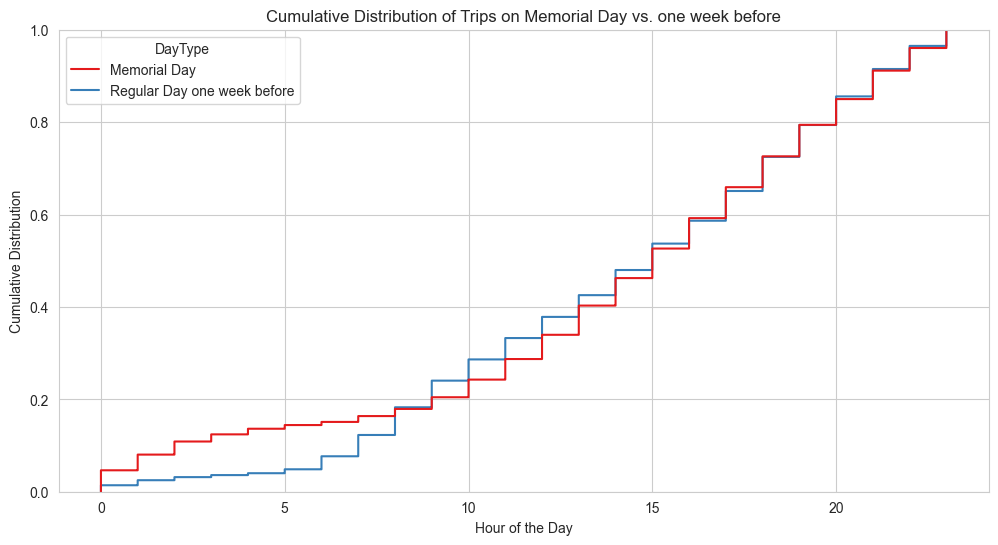

<Figure size 640x480 with 0 Axes>

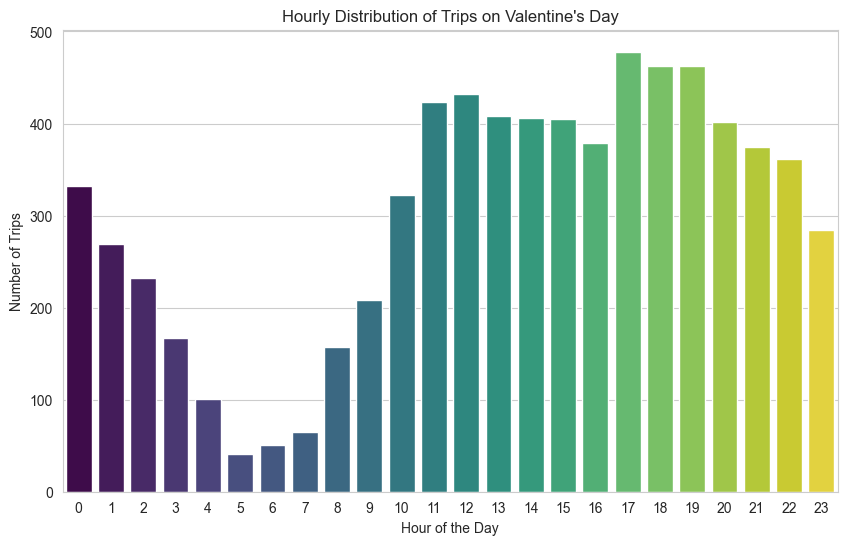

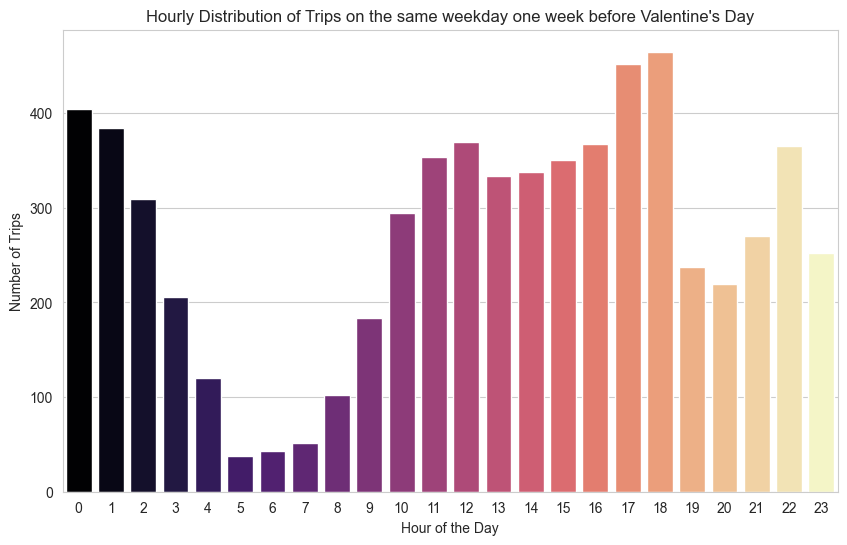

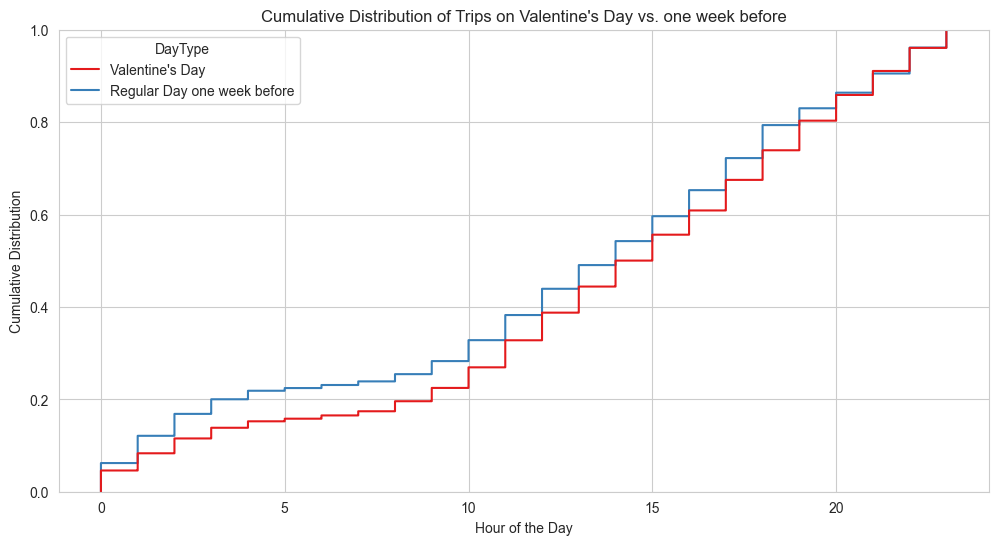

<Figure size 640x480 with 0 Axes>

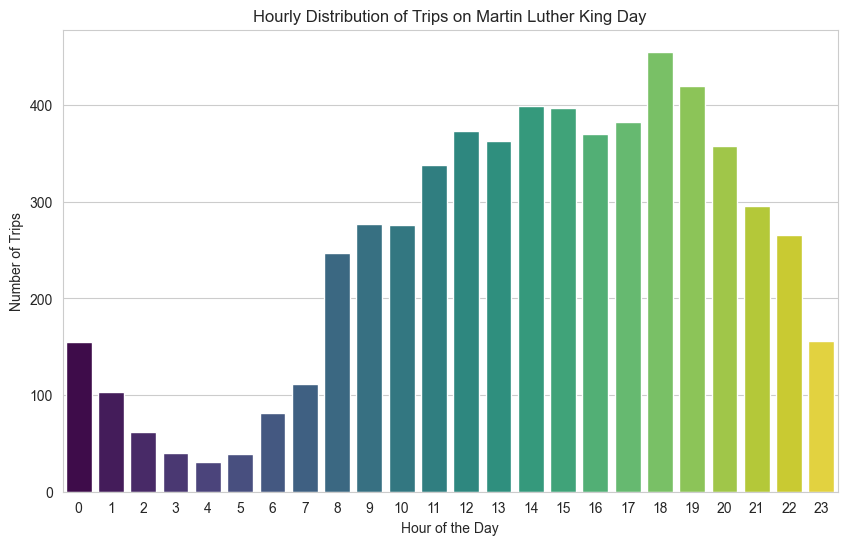

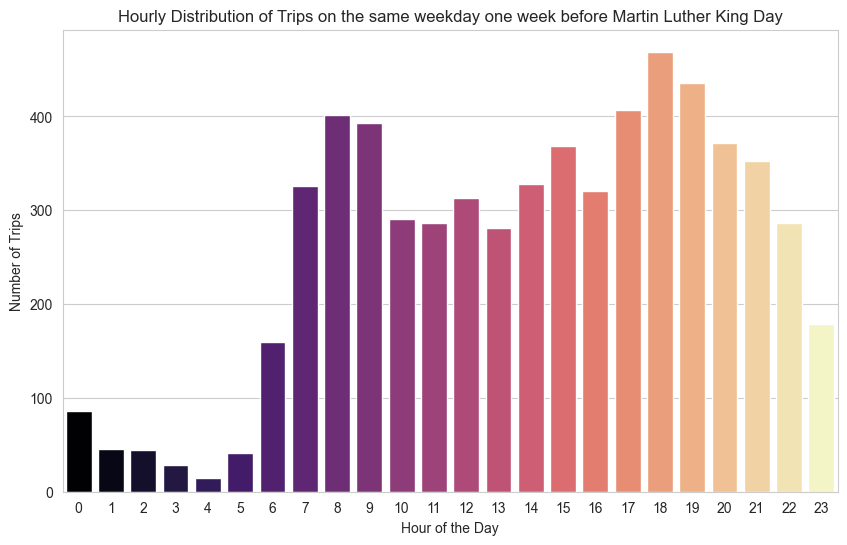

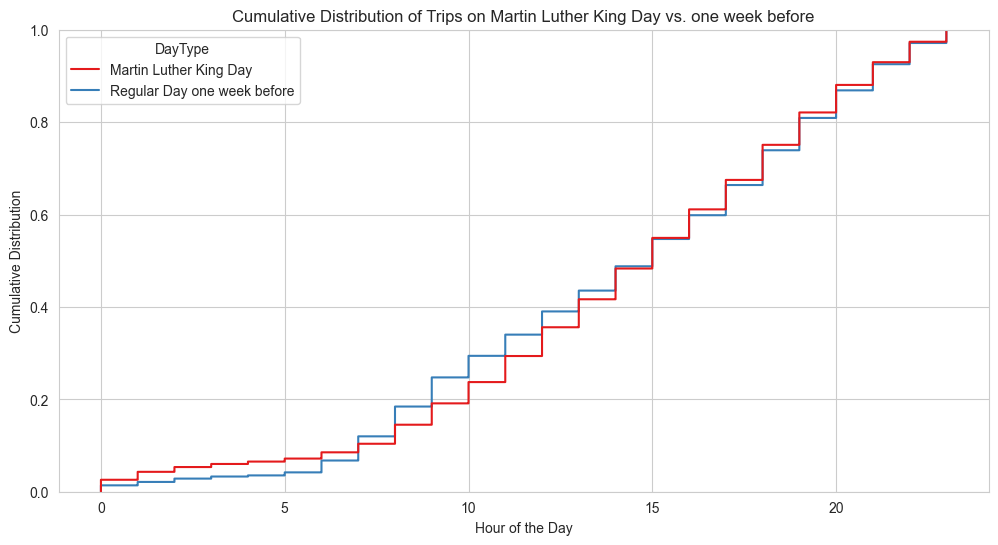

<Figure size 640x480 with 0 Axes>

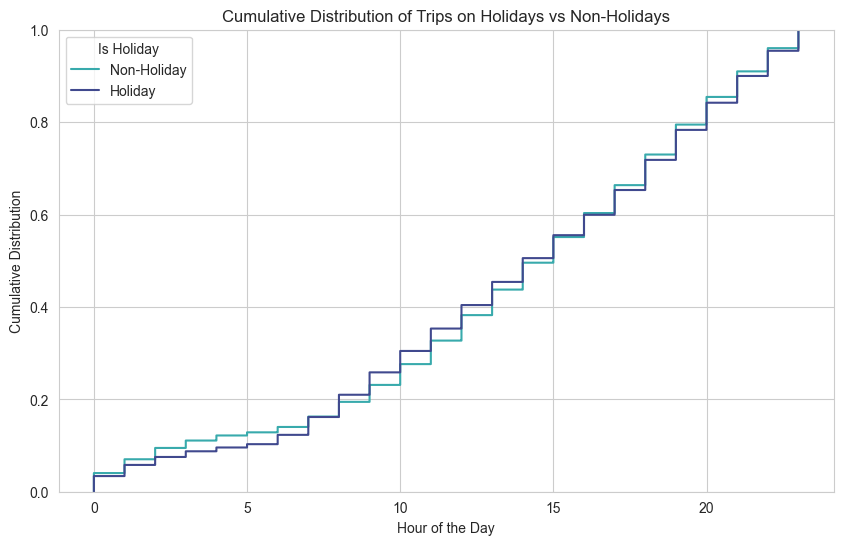

In [39]:

output_folder = "./Plots/Plots[3]/Plots[3.4]"

# Define major holidays in 2016
holidays_2016 = {
    'St. Patrick\'s Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    'Valentine\'s Day': '2016-02-14',
    'Martin Luther King Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays_2016.values()))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Create a new column indicating whether the trip occurred on a major holiday
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holiday_dates)

# Compare trip counts on holidays vs non-holidays
holiday_vs_nonholiday_counts = df['is_holiday'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_vs_nonholiday_counts, hue=['Non-Holiday', 'Holiday'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Holidays vs Non-Holidays')
# Save the figure
plt.savefig(os.path.join(output_folder, "trips_holidays_vs_nonholidays.png"))
plt.show()

# Analyze differences during holidays
for holiday, date in holidays_2016.items():
    holiday_data = df[df['pickup_datetime'].dt.date == pd.to_datetime(date).date()]
    
    # Calculate the date exactly one week before
    one_week_before_date = pd.to_datetime(date) - pd.Timedelta(weeks=1)
    
    # Ensure the date one week before is not a major holiday
    while one_week_before_date in holiday_dates:
        one_week_before_date -= pd.Timedelta(weeks=1)
    
    one_week_before_data = df[df['pickup_datetime'].dt.date == one_week_before_date.date()]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=holiday_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='viridis')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on {holiday}')
    plt.savefig(os.path.join(output_folder, f"{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Compare to the date exactly one week before
    plt.figure(figsize=(10, 6))
    sns.countplot(data=one_week_before_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='magma')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on the same weekday one week before {holiday}')
    plt.savefig(os.path.join(output_folder, f"one_week_before_{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Step 6: Cumulative distribution function (CDF)
    combined_data = pd.concat([holiday_data.assign(DayType=holiday), one_week_before_data.assign(DayType='Regular Day one week before')])

    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=combined_data, x='pickup_hour', hue='DayType', palette='Set1')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Cumulative Distribution of Trips on {holiday} vs. one week before')
    plt.savefig(os.path.join(output_folder, f"cdf_{holiday.replace(' ', '_').lower()}_vs_one_week_before.png"))
    plt.show()

    plt.clf()

# Holiday vs. Non-Holiday Cumulative Distribution
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='pickup_hour', hue='is_holiday', palette='mako')
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trips on Holidays vs Non-Holidays')
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'])
plt.savefig(os.path.join(output_folder, "cdf_holidays_vs_nonholidays.png"))
plt.show()

**Analyzing the Differences Between Holiday and Non-Holiday Trip Patterns**

Based on the CDF plots, we can observe several key differences in trip patterns between holidays and non-holidays:

1. **Delayed Starts:** The CDF for holidays consistently starts lower than the CDF for non-holidays, indicating fewer trips in the early hours on holidays. This suggests a delayed start to the day compared to regular days.
2. **Extended Evening Hours:** The CDF for holidays consistently ends higher than the CDF for non-holidays, indicating a higher proportion of trips occurring later in the evening on holidays. This suggests extended activities or a different pattern of evening travel.
3. **Mid-Day Similarity:** While the early and late hours show significant differences, the lines for holidays and non-holidays tend to converge around the mid-day and afternoon hours. This suggests that trip patterns during these times are relatively similar, with less variation between holidays and non-holidays.

**Overall, the analysis indicates that while the general pattern of trip accumulation over the day is similar for holidays and non-holidays, there are notable differences in the timing of trips.** Holidays are characterized by delayed starts and extended evening hours, suggesting that social and leisure activities play a significant role in shaping travel behavior on these days.

**[3.5]** How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

**Steps:**
- Calculate Average Speed per Hour: Group the data by the hour of the day and calculate the mean speed for each hour.
- Plot the Average Speed: Create a line plot to visualize how average speed changes throughout the day.
- Identify the Fastest Time of Day: Highlight the hour(s) where the average speed is the highest.

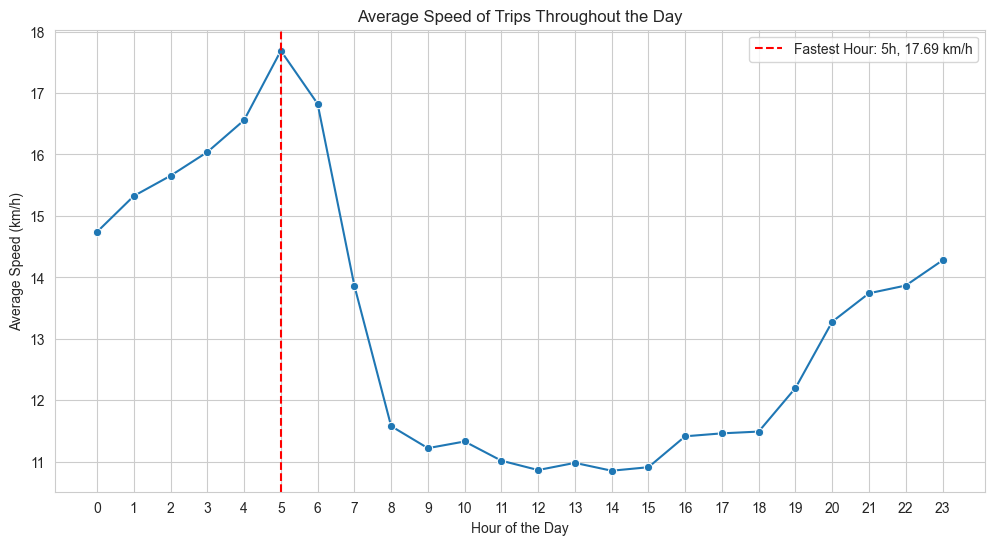

The fastest time of day is around 5:00 with an average speed of 17.69 km/h.


<Figure size 640x480 with 0 Axes>

In [40]:
# Calculate the average speed per hour
avg_speed_per_hour = df.groupby('pickup_hour')['speed_kmh'].mean()

# Step 2: Plot the average speed throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_per_hour.index, y=avg_speed_per_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed of Trips Throughout the Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on the x-axis
plt.grid(True)

# Highlight the hour(s) with the highest average speed
fastest_hour = avg_speed_per_hour.idxmax()
fastest_speed = avg_speed_per_hour.max()
plt.axvline(x=fastest_hour, color='red', linestyle='--', label=f'Fastest Hour: {fastest_hour}h, {fastest_speed:.2f} km/h')
plt.legend()

plt.savefig('./Plots/Plots[3]/Plots[3.5]/average_speed_throughout_day.png')

plt.show()
plt.clf()

print(f"The fastest time of day is around {fastest_hour}:00 with an average speed of {fastest_speed:.2f} km/h.")


### Question 4: Location clusters
**[4.1]** Heatmaps

Produce a heatmap of all of the trip pickups over (do not do a scatter plot... there are 1.5 million data points and this will almost certainly crash your computer):
1. weekdays and weekends,
2. morning and evening (choose reasonable hours).

Comment on any findings you make.

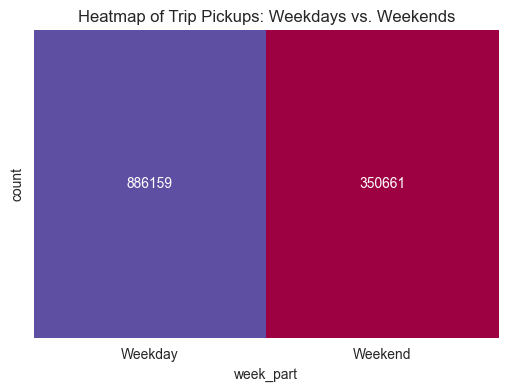

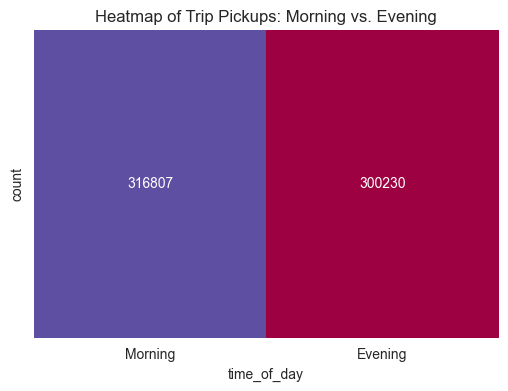

In [41]:
df['week_part'] = df['day_of_week_str'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

week_part_counts = df['week_part'].value_counts().reindex(['Weekday', 'Weekend']).fillna(0).reset_index()
week_part_counts.columns = ['week_part', 'count']
heatmap_data = week_part_counts.set_index('week_part').T

#plot heatmap for weekdays vs weekends
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Spectral", cbar=False)
plt.title('Heatmap of Trip Pickups: Weekdays vs. Weekends')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_weekdays_vs_weekends.png')
plt.show()

time_of_day_counts = df['time_of_day'].value_counts().reindex(['Morning', 'Evening']).fillna(0).reset_index()
time_of_day_counts.columns = ['time_of_day', 'count']
heatmap_data = time_of_day_counts.set_index('time_of_day').T

#plot heatmap for morning vs evening
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Spectral", cbar=False)
plt.title('Heatmap of Trip Pickups: Morning vs. Evening')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_morning_vs_evening.png')
plt.show()

1. The heatmap data reveals that weekdays have significantly more total pickups (886259) compared to weekends (350661), reflecting higher weekday travel due to work-related activities. However, the weekend's total is distributed over just 2 days compared to 5 weekdays, resulting in similar average daily pickup counts: approximately 177252 on weekdays and 175331 on weekends. This indicates that while weekdays have a higher cumulative total, the demand on weekends is nearly as high on a daily basis.
2. Morning pickups slightly surpass evening pickups, with 316807 trips occurring in the morning and 300230 in the evening. Despite mornings covering a broader time range (7 hours) compared to evenings (4 hours), the relatively close totals suggest a high level of demand throughout both periods. This suggests that both morning and evening times are critical for transportation services, with significant activity during these peak hours.

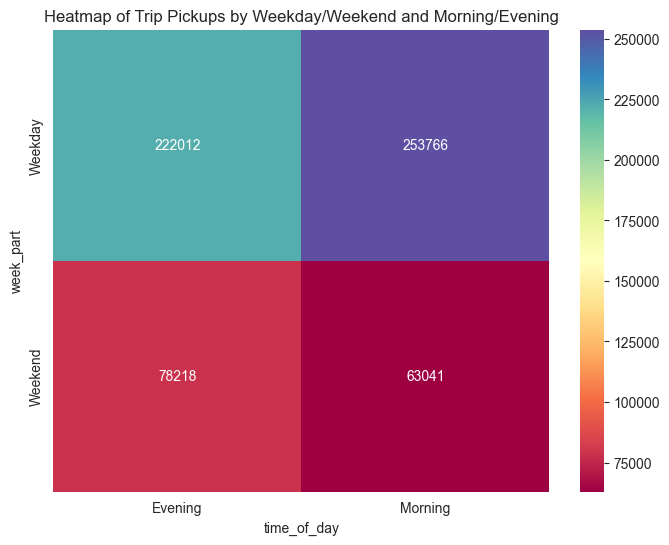

In [42]:
df['week_part'] = df['day_of_week_str'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
planning_data = df[df['time_of_day'].isin(['Morning', 'Evening'])]

#pivot table to count pickups
pivot_table = planning_data.pivot_table(index='week_part', columns='time_of_day', aggfunc='size', fill_value=0)

#plot heatmap of weekdays, weekends, mornings and evenings
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Spectral")
plt.title('Heatmap of Trip Pickups by Weekday/Weekend and Morning/Evening')
plt.savefig('./Plots/Plots[4]/Plots[4.1]/heatmap_of_all.png')
plt.show()

 Weekday pickups are higher in the morning (253766) compared to the evening (222012), reflecting typical workday commuting patterns. Conversely, weekend pickups are more frequent in the evening (78218) than in the morning (63041), aligning with common social and recreational activities that peak during weekends. This trend highlights that weekdays have higher overall trip volumes due to regular work routines, while weekends see a shift towards more evening trips. 

**[4.2]** Hotspots

If you were a taxi driver wanting to plan your evenings so that you could get the most trips, you would want to know where the popular areas are. Looking at the time periods 23:00 on a Friday evening to 02:00 on a Saturday morning, and between 17:00 and 20:00 on a Thursday, find hotspot locations (areas where there are a large number of trips happening). If you were to use k-means, you would define the number of clusters. However, here the number of clusters is not at all clear. DBSCAN (available in sklearn) determines this for you, and works well on spatial data. DBSCAN has two configurable parameters: ε-the maximum distance between any two points, and the minimum number of samples to determine a cluster. Your hotspot location might be defined as at least 15 pickups in that location in an hour, and locations might be required to be within 50 or 100 metres from each other (motivate your choice of parameters). Using DBSCAN, identify clusters and plot these on a map. How many clusters did you find? 

Number of clusters: 44


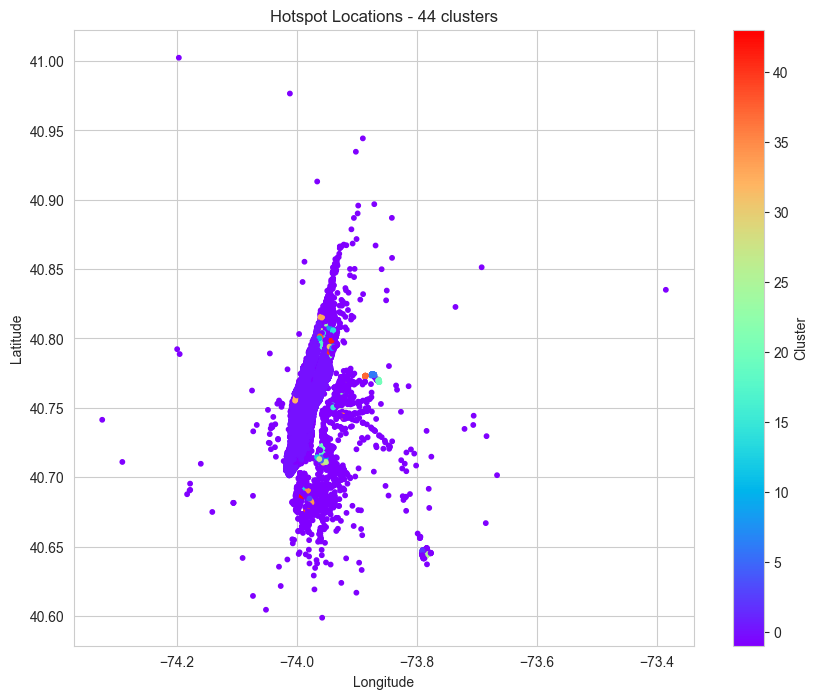

KeyboardInterrupt: 

In [43]:
friday_evening = df[(df['pickup_datetime'].dt.dayofweek == 4) & 
                      (df['pickup_datetime'].dt.hour >= 23) | 
                      (df['pickup_datetime'].dt.dayofweek == 5) & 
                      (df['pickup_datetime'].dt.hour < 2)]

thursday_evening = df[(df['pickup_datetime'].dt.dayofweek == 3) & 
                        (df['pickup_datetime'].dt.hour >= 17) & 
                        (df['pickup_datetime'].dt.hour < 20)]

planning_data = pd.concat([friday_evening, thursday_evening])
coords = planning_data[['pickup_latitude', 'pickup_longitude']].values

max_distance = 0.1  #0.1 because thats 100m in km
min_cars = 15
kms_per_radian = 6371.0088
epsilon = max_distance / kms_per_radian
#apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_cars, algorithm='ball_tree', metric='haversine')
clusters = db.fit_predict(np.radians(coords))

#add the cluster labels back to the dataframe
planning_data['cluster'] = clusters

#number of clusters
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {n_clusters}")

# Plot the clusters on a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(planning_data['pickup_longitude'], planning_data['pickup_latitude'], c=planning_data['cluster'], cmap='rainbow', s=10)
plt.title(f"Hotspot Locations - {n_clusters} clusters")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.savefig('./Plots/Plots[4]/Plots[4.2]/clusters_scatter_plot.png')
plt.show()

#coordinates of New York City
nyc_lat, nyc_lon = 40.7128, -74.0060
cluster_map = folium.Map(location=[nyc_lat, nyc_lon], tiles="CartoDB Positron", zoom_start=11)
colormap = plt.colormaps.get_cmap('tab20')
#add DBSCAN clusters to the map
for lat, lon, cluster in zip(planning_data['pickup_latitude'], planning_data['pickup_longitude'], planning_data['cluster']):
    if cluster != -1:
        color = colormap(cluster % colormap.N)  # Normalize to 0-1 range for color mapping
        color = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'  # Convert to hex
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(cluster_map)
cluster_map.save('nyc_cluster_map.html')
cluster_map

In [25]:
from folium import plugins

heat_data = [[row['pickup_latitude'], row['pickup_longitude']] for index, row in planning_data.iterrows()]
heatmap = folium.Map(location=[nyc_lat, nyc_lon], zoom_start=10, tiles='Cartodb dark_matter')
plugins.HeatMap(heat_data).add_to(heatmap)
heatmap.save('nyc_heatmap.html')
heatmap

### Question 5: Airports

Find out how long it takes, on average, to travel to JFK airport from the Empire State Building. Produce a plot showing the travel time by time of day. How does this compare with Newark Airport? Assume the following coordinates for the centre point of the locations (long, lat):

- JFK Airport: (40.647929, -73.777813)
- Empire State Building: (40.756724, -73.983806)
- Newark Airport: (40.689442, -74.173242)

Use a reasonable (and motivate!) radius around these locations when determining if a GPS coordinate is at that location. [9 marks]

To do / plan:

- how long it takes to get to JFK from Empire State Building.
- pick a revelent radius for the airports and building
- calculate travel times
- separate/ organise by time of the day.
- plot graph, histogram?

travel time:  trip_duration_min
locations:
    start: pickup_longitude and pickup_latitude
    end: dropoff_longitude and dropoff_latitude

- new dataframe that has:
    - only data from relevant trips ( ie the airport trips)
    - travel times
    - time of day of the trips

In [30]:
# Read the cleaned dataset
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv')

airport_trips_traveltimes_df = df.copy()
not_relevant_columns = airport_trips_traveltimes_df.columns.to_list()
not_relevant_columns.remove("pickup_longitude")
not_relevant_columns.remove("pickup_latitude")
not_relevant_columns.remove("dropoff_longitude")
not_relevant_columns.remove("dropoff_latitude")
not_relevant_columns.remove("trip_duration_min")
not_relevant_columns.remove("time_of_day")
airport_trips_traveltimes_df.drop(not_relevant_columns, axis=1, inplace=True)

# selecting only the locations that are within the radius of the ESB and Airports.
# adding a flag to signal which location the record is for, for both pick up and dropoff.

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = builtins.map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# use haversine_np function with the locations and each record's co-ords. 
# check if return from haversine_np is within/smaller than decided radius,
# if true, keep in dataframe and add location flag, else remove from dataframe.


# JFK = JFK Airport
# ESB = Empire State Building
# Newark = Newark Airport

JFK_LAT =  40.647929
JFK_LONG =  -73.777813

ESB_LAT =  40.756724
ESB_LONG = -73.983806

NEWARK_LAT = 40.689442
NEWARK_LONG = -74.173242

radius_esb = 17.5 # TODO: re-evaluate radius
radius_airport = 10

#for i in range(len(airport_trips_traveltimes_df)):
#    
#    # pickup locations
#    pickup_long = airport_trips_traveltimes_df.loc[i, 'pickup_longitude']
#    pickup_lat =  airport_trips_traveltimes_df.loc[i, 'pickup_latitude']
#    if haversine_np(JFK_LONG, JFK_LAT, pickup_long, pickup_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'pickup_location'] = "JFK"
#    elif haversine_np(ESB_LONG, ESB_LAT, pickup_long, pickup_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'pickup_location'] = "ESB"
#    elif haversine_np(NEWARK_LONG, NEWARK_LAT, pickup_long, pickup_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'pickup_location'] = "Newark"
#    else:
#        airport_trips_traveltimes_df.loc[i,'pickup_location'] = "NA"
#    
#    # dropoff locations
#    dropoff_long = airport_trips_traveltimes_df.loc[i,'dropoff_longitude']
#    dropoff_lat = airport_trips_traveltimes_df.loc[i, 'dropoff_latitude']
#    if haversine_np(JFK_LONG, JFK_LAT, dropoff_long, dropoff_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'dropoff_location'] = "JFK"
#    elif haversine_np(ESB_LONG, ESB_LAT, dropoff_long, dropoff_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'dropoff_location'] = "ESB"
#    elif haversine_np(NEWARK_LONG, NEWARK_LAT, dropoff_long, dropoff_lat) <= RADIUS:
#        airport_trips_traveltimes_df.loc[i,'dropoff_location'] = "Newark"
#    else:
#        airport_trips_traveltimes_df.loc[i,'dropoff_location'] = "NA"
        

def pickupLocation(row):
    pickup_long = row['pickup_longitude']
    pickup_lat =  row['pickup_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, pickup_long, pickup_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, pickup_long, pickup_lat) <= radius_airport:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, pickup_long, pickup_lat) <= radius_airport:
        return "Newark"
    else:
        return "NA"
    
def dropoffLocation(row):
    dropoff_long = row['dropoff_longitude']
    dropoff_lat = row['dropoff_latitude']
    if haversine_np(ESB_LONG, ESB_LAT, dropoff_long, dropoff_lat) <= radius_esb:
        return "ESB"
    elif haversine_np(JFK_LONG, JFK_LAT, dropoff_long, dropoff_lat) <= radius_airport:
        return "JFK"
    elif haversine_np(NEWARK_LONG, NEWARK_LAT, dropoff_long, dropoff_lat) <= radius_airport:
        return "Newark"
    else:
        return "NA"


airport_trips_traveltimes_df['pickup_location'] = ""
airport_trips_traveltimes_df['dropoff_location'] = ""

airport_trips_traveltimes_df['pickup_location'] = airport_trips_traveltimes_df.apply(pickupLocation, axis = 1)
# display(airport_trips_traveltimes_df)
airport_trips_traveltimes_df['dropoff_location'] = airport_trips_traveltimes_df.apply(dropoffLocation, axis = 1)
display(airport_trips_traveltimes_df[airport_trips_traveltimes_df["dropoff_location"] == "JFK"])
display(airport_trips_traveltimes_df[(airport_trips_traveltimes_df["dropoff_location"] == "JFK") & (airport_trips_traveltimes_df["pickup_location"] != "JFK")])
display(airport_trips_traveltimes_df[airport_trips_traveltimes_df["pickup_location"] == "ESB"])
#indexLocation = df[ (df['Age'] >= 20) & (df['Age'] <= 25) ].index
#df.drop(indexLocation , inplace=True)
#df.head(15)

# pickup_location has to be Empire State Building

#indexLocation_dropoff = airport_trips_traveltimes_df[((airport_trips_traveltimes_df['pickup_location'] != "ESB"))].index# & ((airport_trips_traveltimes_df['dropoff_location'] != "ESB") | (airport_trips_traveltimes_df['dropoff_location'] != "NA"))].index
#((airport_trips_traveltimes_df['pickup_location'] != "ESB")) 
#airport_trips_traveltimes_df.drop(indexLocation_dropoff, inplace = True)

new_df = airport_trips_traveltimes_df[(airport_trips_traveltimes_df['pickup_location'] == "ESB") & ((airport_trips_traveltimes_df['dropoff_location'] == "JFK") |(airport_trips_traveltimes_df['dropoff_location'] == "Newark")) ]

display(airport_trips_traveltimes_df[(airport_trips_traveltimes_df['pickup_location'] == "ESB") & (airport_trips_traveltimes_df['dropoff_location'] == "JFK")])

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_min,time_of_day,pickup_location,dropoff_location
586,-73.786720,40.647041,-73.786720,40.647041,9.666667,Evening,JFK,JFK
708,-73.782372,40.648766,-73.782372,40.648746,0.050000,Afternoon,JFK,JFK
1070,-73.789932,40.643665,-73.790169,40.688728,12.916667,Night,JFK,JFK
1451,-73.776314,40.645454,-73.776314,40.645454,0.316667,Afternoon,JFK,JFK
1655,-73.789803,40.647228,-73.809502,40.670158,7.633333,Morning,JFK,JFK
...,...,...,...,...,...,...,...,...
1234560,-73.789970,40.647030,-73.789970,40.647030,0.633333,Evening,JFK,JFK
1234922,-73.776703,40.645382,-73.776840,40.645912,2.816667,Morning,JFK,JFK
1235084,-73.789665,40.646984,-73.789658,40.646976,0.150000,Evening,JFK,JFK
1235145,-73.776741,40.645260,-73.712242,40.633598,21.383333,Night,JFK,JFK


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_min,time_of_day,pickup_location,dropoff_location
39097,-73.791504,40.704685,-73.787865,40.684582,8.316667,Afternoon,ESB,JFK
91174,-73.797821,40.709251,-73.783600,40.685329,17.316667,Morning,ESB,JFK
145974,-73.802544,40.707710,-73.788963,40.691315,6.800000,Night,ESB,JFK
172678,-73.824150,40.686111,-73.800171,40.669903,17.150000,Evening,ESB,JFK
176891,-73.793678,40.697605,-73.729111,40.697666,19.750000,Afternoon,ESB,JFK
323015,-73.802551,40.705490,-73.794067,40.656990,16.183333,Morning,ESB,JFK
445114,-73.847908,40.723450,-73.779442,40.691780,24.816667,Night,ESB,JFK
464548,-73.817177,40.702450,-73.793869,40.667301,10.083333,Evening,ESB,JFK
490454,-73.819458,40.675266,-73.790047,40.646893,10.416667,Morning,ESB,JFK
514227,-73.867393,40.676208,-73.805588,40.674667,12.116667,Night,ESB,JFK


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_min,time_of_day,pickup_location,dropoff_location
0,-73.982155,40.767937,-73.964630,40.765602,7.583333,Evening,ESB,ESB
1,-73.980415,40.738564,-73.999481,40.731152,11.050000,Night,ESB,ESB
2,-74.010040,40.719971,-74.012268,40.706718,7.150000,Evening,ESB,ESB
3,-73.973053,40.793209,-73.972923,40.782520,7.250000,Afternoon,ESB,ESB
4,-73.982857,40.742195,-73.992081,40.749184,7.383333,Night,ESB,ESB
...,...,...,...,...,...,...,...,...
1236815,-73.975357,40.751705,-73.949478,40.776764,12.666667,Evening,ESB,ESB
1236816,-73.988823,40.736553,-73.989166,40.757393,6.900000,Night,ESB,ESB
1236817,-73.982201,40.745522,-73.994911,40.740170,12.966667,Afternoon,ESB,ESB
1236818,-73.982079,40.749062,-73.974632,40.757107,6.216667,Afternoon,ESB,ESB


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_min,time_of_day,pickup_location,dropoff_location
39097,-73.791504,40.704685,-73.787865,40.684582,8.316667,Afternoon,ESB,JFK
91174,-73.797821,40.709251,-73.783600,40.685329,17.316667,Morning,ESB,JFK
145974,-73.802544,40.707710,-73.788963,40.691315,6.800000,Night,ESB,JFK
172678,-73.824150,40.686111,-73.800171,40.669903,17.150000,Evening,ESB,JFK
176891,-73.793678,40.697605,-73.729111,40.697666,19.750000,Afternoon,ESB,JFK
323015,-73.802551,40.705490,-73.794067,40.656990,16.183333,Morning,ESB,JFK
445114,-73.847908,40.723450,-73.779442,40.691780,24.816667,Night,ESB,JFK
464548,-73.817177,40.702450,-73.793869,40.667301,10.083333,Evening,ESB,JFK
490454,-73.819458,40.675266,-73.790047,40.646893,10.416667,Morning,ESB,JFK
514227,-73.867393,40.676208,-73.805588,40.674667,12.116667,Night,ESB,JFK
